# Wind Turbines analysis

In [27]:
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import pydeck as pdk
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from data_analysis import DataAnalysis
import matplotlib.pyplot as plt
import seaborn as sns

## Extract turbines inside Texas territory

In [28]:
# Load the wind turbine locations shape file
wind_turbine_shapefile_path = "../data/uswtdbSHP/uswtdb_v7_0_20240510.shp"
wind_turbine_shapefile = gpd.read_file(wind_turbine_shapefile_path)

# Select only the wind turbines in Texas
wind_turbines_in_texas = wind_turbine_shapefile[wind_turbine_shapefile['t_state'] == 'TX']

# Define a layer to display on a map
layer = pdk.Layer(
    'ScatterplotLayer',
    wind_turbines_in_texas,
    get_position='[xlong, ylat]',
    get_color=[200, 30, 0, 160],
    get_radius=500,)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=wind_turbines_in_texas['xlong'].mean(),
    latitude=wind_turbines_in_texas['ylat'].mean(),
    zoom=6,
    min_zoom=1,
    max_zoom=15)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.show()


DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{\n  "initialViewState": {…

# Filter the wind turbines build before 2012

In [30]:
def safe_convert(val):
    try:
        return int(val[:4])
    except ValueError:
        return np.nan

filtered_df = wind_turbines_in_texas.copy()
filtered_df['faa_asn'] = filtered_df['faa_asn'].apply(safe_convert)
filtered_df = filtered_df[filtered_df['faa_asn'] <= 2012]


layer = pdk.Layer(
    'ScatterplotLayer',
    filtered_df,
    get_position='[xlong, ylat]',  
    get_radius=50,
    get_fill_color='[200, 30, 0]',
    pickable=True,
    auto_highlight=True
)

view_state = pdk.ViewState(
    longitude=filtered_df['xlong'].mean(),
    latitude=filtered_df['ylat'].mean(),
    zoom=6,
    min_zoom=1,
    max_zoom=15)

r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.show()

r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.show()

DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{\n  "initialViewState": {…

## Run DBSCAN algorithm to detect clusters

In [31]:

points = filtered_df.geometry.apply(lambda point: (point.x, point.y)).tolist()

epsilon = 0.1  # Distance threshold for clustering
min_samples = 5  # Minimum number of points required to form a cluster
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = dbscan.fit_predict(points)

# Add the cluster labels to the GeoDataFrame
filtered_df['cluster_label'] = labels

# Print the number of clusters found
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters found: {num_clusters}")

# Create a scatter plot by assigning different colors to the clusters using pdk

layer = pdk.Layer(
    'ScatterplotLayer',
    filtered_df,
    get_position='[xlong, ylat]',  
    get_radius=50,
    get_fill_color='[200, cluster_label*15, 0]',
    pickable=True,
    auto_highlight=True
)

r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.show()

Number of clusters found: 34


DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{\n  "initialViewState": {…

## Calculate the centroid of each cluster

In [33]:
centroids = []
for cluster_label in range(num_clusters):
    cluster_points = filtered_df[filtered_df['cluster_label'] == cluster_label]
    centroid = np.mean(cluster_points[['xlong', 'ylat']], axis=0)
    centroids.append(centroid)

centroids_df = pd.DataFrame(centroids, columns=['xlong', 'ylat'])


centroid_layer = pdk.Layer(
    'ScatterplotLayer',
    data=centroids_df,  # Use the DataFrame here
    get_position='[xlong, ylat]',  # Use the column names here
    get_radius=4000,
    get_fill_color='[0, 191, 255]',
    pickable=True,
    auto_highlight=True
)

r = pdk.Deck(layers=[layer, centroid_layer], initial_view_state=view_state)
r.show()


DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{\n  "initialViewState": {…

## Create a GeoDataFrame from the centroids DataFrame

In [6]:
centroids_gdf = gpd.GeoDataFrame(
    centroids_df,
    geometry=gpd.points_from_xy(centroids_df['xlong'], centroids_df['ylat'])
)

# Save the GeoDataFrame to a csv file
#centroids_gdf.to_csv("centroids.csv", index=False)

# Add a cluster_label column to the centroids DataFrame
centroids_df['cluster_label'] = range(len(centroids_df))

# Merge the centroids_df with the clusters_gdf
clusters_gdf = filtered_df.copy()
clusters_gdf = clusters_gdf.merge(centroids_df, on='cluster_label', suffixes=('', '_centroid'))

# Save the clusters_gdf to a csv file
#clusters_gdf.to_csv("clusters.csv", index=False)

## Test NREL windtoolkit with the centroids coordinates

In [24]:
for ii in range(1):
    lat = centroids_gdf['ylat'].iloc[ii]
    lon = centroids_gdf['xlong'].iloc[ii]
    year = 2012
    df = DataAnalysis(lat, lon, year).monthly_data()


0     Year Month Day Hour Minute wind speed at 10m (m/s)  \
1     2012     1   1    0     30      2.7600000000000002   
2     2012     1   1    1     30                     2.5   
3     2012     1   1    2     30      2.3000000000000003   
4     2012     1   1    3     30                    3.96   
5     2012     1   1    4     30                    3.85   
...    ...   ...  ..  ...    ...                     ...   
8780  2012    12  31   19     30                    3.52   
8781  2012    12  31   20     30                    3.64   
8782  2012    12  31   21     30                    4.61   
8783  2012    12  31   22     30                    3.87   
8784  2012    12  31   23     30                    1.46   

0    wind speed at 60m (m/s) wind speed at 100m (m/s)  \
1          7.640000000000001       11.370000000000001   
2                       7.11                    10.56   
3                       5.17                     8.47   
4                       5.78                     7.

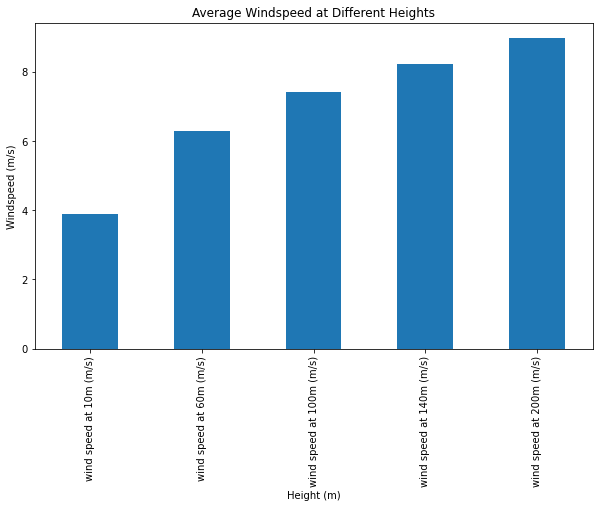

In [25]:

heights = ['wind speed at 10m (m/s)', 'wind speed at 60m (m/s)', 'wind speed at 100m (m/s)', 'wind speed at 140m (m/s)', 'wind speed at 200m (m/s)']
average_speeds = df[heights].mean()
average_speeds.plot(kind='bar', figsize=(10, 6))
plt.title('Average Windspeed at Different Heights')
plt.ylabel('Windspeed (m/s)')
plt.xlabel('Height (m)')
plt.show()

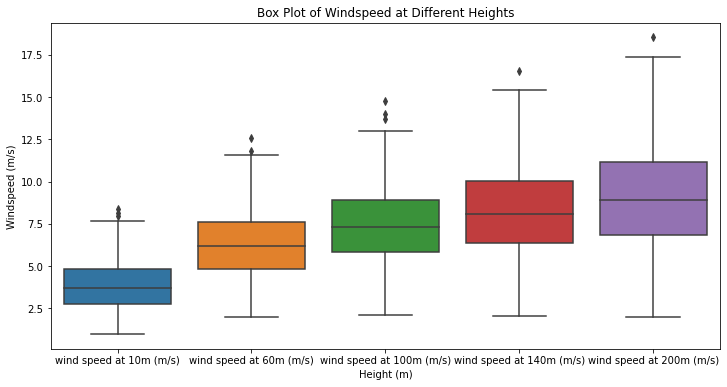

In [26]:
melted_df = df[heights].melt(var_name='Height', value_name='Windspeed', ignore_index=False)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Height', y='Windspeed', data=melted_df)
plt.title('Box Plot of Windspeed at Different Heights')
plt.ylabel('Windspeed (m/s)')
plt.xlabel('Height (m)')
plt.show()